# Describing Data by Batch

In [1]:
import os
import numpy as np
import pandas as pd
import plotnine as gg

from pycytominer.cyto_utils import infer_cp_features

from scripts.processing_utils import load_data

In [2]:
def get_count_per_batch(df, batch_name):
    result = (
        df
        .Metadata_Plate
        .value_counts()
        .reset_index()
        .rename({
            "index": "Metadata_Plate",
            "Metadata_Plate": "profile_count"
        }, axis="columns")
        .assign(batch=batch_name)
    )
    return result

def count_treatments_per_plate(df, batch_name):
    
    if batch_name in ["2019_02_15_Batch1_20X", "2019_02_15_Batch1_40X", "2019_03_20_Batch2"]:
        group_cols = ["Metadata_CellLine", "Metadata_Dosage", "Metadata_Plate"]
    elif batch_name in ["2019_06_25_Batch3"]:
        group_cols = ["Metadata_clone_number", "Metadata_Plate"]
    else:
        group_cols = ["Metadata_clone_number", "Metadata_treatment", "Metadata_Plate"]

    result = (
        df
        .groupby(group_cols)
        ["Metadata_Well"]
        .count()
        .reset_index()
        .rename({
            "Metadata_Well": "profile_count",
            group_cols[0]: "Metadata_clone"
        }, axis="columns")
        .assign(batch=batch_name)
    )
    
    if batch_name not in ["2019_06_25_Batch3"]:
        result = (
            result.rename({
                group_cols[1]: "Metadata_treatment"
            }, axis="columns")
        )
    return result

def process_counts(batch_name, profile_dir="profiles"):
    df = load_data(batch_name, profile_dir, combine_dfs=True)
    batch_count = get_count_per_batch(df, batch_name)
    treatment_count = count_treatments_per_plate(df, batch_name)
    return df, batch_count, treatment_count

In [3]:
profile_dir = os.path.join("..", "0.generate-profiles", "profiles")
batches = [x for x in os.listdir(profile_dir) if x != ".DS_Store"]

batches

['2019_02_15_Batch1_40X',
 '2019_03_20_Batch2',
 '2019_06_25_Batch3',
 '2019_11_11_Batch4',
 '2019_11_20_Batch6',
 '2019_02_15_Batch1_20X',
 '2019_11_19_Batch5',
 '2019_11_22_Batch7']

In [4]:
batch_data = {}
all_clones = list()
profile_count_list = list()
for batch in batches:
    print("Now processing... {}".format(batch))
    df, batch_count, treatment_count = process_counts(batch, profile_dir=profile_dir)
    
    batch_data[batch] = {
            "dataframe": df,
            "metafeatures": infer_cp_features(df, metadata=True),
            "batch_count": batch_count,
            "treatment_count": treatment_count
        }
    
    all_clones += treatment_count.Metadata_clone.unique().tolist()
    profile_count_list.append(
        treatment_count.loc[:, ["Metadata_clone", "Metadata_treatment", "profile_count"]]
    )

Now processing... 2019_02_15_Batch1_40X
Now processing... 2019_03_20_Batch2
Now processing... 2019_06_25_Batch3
Now processing... 2019_11_11_Batch4
Now processing... 2019_11_20_Batch6
Now processing... 2019_02_15_Batch1_20X
Now processing... 2019_11_19_Batch5
Now processing... 2019_11_22_Batch7


In [5]:
sample_count_df = (
    pd.DataFrame(
        pd.concat(profile_count_list, axis="rows")
        .fillna("DMSO")
        .reset_index(drop=True)
        .groupby(["Metadata_clone", "Metadata_treatment"])
        ["profile_count"]
        .sum()
    )
    .sort_values("profile_count", ascending=False)
    .reset_index()
)

sample_count_df

,Metadata_clone,Metadata_treatment,profile_count
0,WT_parental,DMSO,1164
1,BZ001,DMSO,405
2,BZ008,DMSO,405
3,BZ018,DMSO,405
4,BZ017,DMSO,403
5,WT009,DMSO,402
6,WT008,DMSO,402
7,WT002,DMSO,402
8,WT011,DMSO,401
9,WT011,bortezomib,357


In [6]:
sample_treatment_count_df = (
    sample_count_df
    .pivot_table(values="profile_count", index="Metadata_clone", columns="Metadata_treatment")
    .fillna(0)
    .astype(int)
)

sample_treatment_count_df

Metadata_treatment,0.0,0.7,7.0,70.0,DMSO,bortezomib
Metadata_clone,,,,,,
BZ001,0,0,0,0,405,357
BZ002,0,0,0,0,48,0
BZ003,0,0,0,0,48,0
BZ004,0,0,0,0,48,0
BZ005,0,0,0,0,48,0
BZ006,0,0,0,0,48,0
BZ007,0,0,0,0,48,0
BZ008,0,0,0,0,405,357
BZ009,0,0,0,0,48,0


In [7]:
len(set(all_clones))

37

In [8]:
all_profile_counts = []
for key, value in batch_data.items():
    all_profile_counts.append(batch_data[key]["batch_count"])

profile_counts_df = pd.concat(all_profile_counts, axis="rows")
profile_counts_df

,Metadata_Plate,profile_count,batch
0,HCT116bortezomib,646,2019_02_15_Batch1_40X
0,207106_exposure320,324,2019_03_20_Batch2
0,MutClones,912,2019_06_25_Batch3
1,WTClones,720,2019_06_25_Batch3
0,WTmut04hWed,1020,2019_11_11_Batch4
1,WTmut04hTh,1018,2019_11_11_Batch4
0,217762,1020,2019_11_20_Batch6
1,217760,1018,2019_11_20_Batch6
0,HCT116bortezomib,324,2019_02_15_Batch1_20X
0,217755,1020,2019_11_19_Batch5


In [9]:
all_treatment_counts = []
for key, value in batch_data.items():
    all_treatment_counts.append(batch_data[key]["treatment_count"])

treatment_counts_df = pd.concat(all_treatment_counts, axis="rows", sort=True)
treatment_counts_df.head()

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
0,HCT116bortezomib,CloneA,0,2019_02_15_Batch1_40X,54
1,HCT116bortezomib,CloneA,0.7,2019_02_15_Batch1_40X,54
2,HCT116bortezomib,CloneA,7,2019_02_15_Batch1_40X,54
3,HCT116bortezomib,CloneA,70,2019_02_15_Batch1_40X,54
4,HCT116bortezomib,CloneE,0,2019_02_15_Batch1_40X,53


In [10]:
clone_counts_df = (
    treatment_counts_df
    .groupby(["Metadata_clone", "Metadata_treatment"])
    ["profile_count"]
    .sum()
    .reset_index()
)

output_file = os.path.join("tables", "clone_counts_bortezomib.csv")
clone_counts_df.to_csv(output_file, sep=',', index=False)

clone_counts_df

,Metadata_clone,Metadata_treatment,profile_count
0,BZ001,DMSO,357
1,BZ001,bortezomib,357
2,BZ008,DMSO,357
3,BZ008,bortezomib,357
4,BZ017,DMSO,355
5,BZ017,bortezomib,357
6,BZ018,DMSO,357
7,BZ018,bortezomib,357
8,CloneA,0,108
9,CloneA,0.7,108


## Visualize Counts

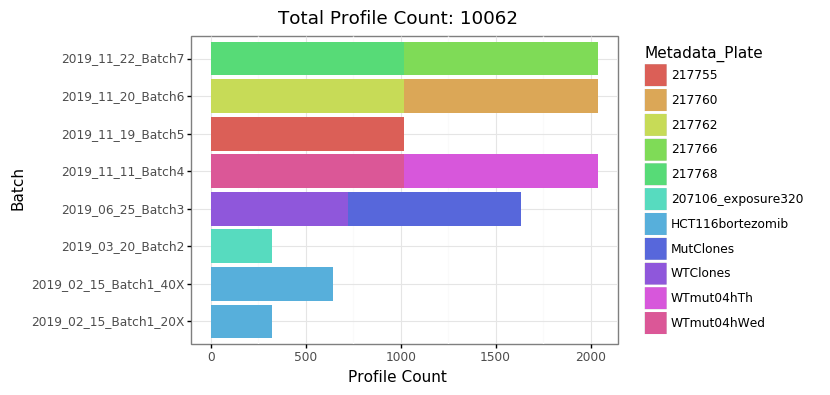

<ggplot: (305896084)>

In [11]:
total_count = profile_counts_df.profile_count.sum()
total_label = "Total Profile Count: {}".format(total_count)

batch_count_gg = (
    gg.ggplot(profile_counts_df, gg.aes(y="profile_count", x="batch")) +
    gg.geom_bar(gg.aes(fill="Metadata_Plate"), stat="identity") +
    gg.coord_flip() +
    gg.theme_bw() +
    gg.ylab("Profile Count") +
    gg.xlab("Batch") +
    gg.ggtitle(total_label)
)

output_figure = os.path.join("figures", "batch_count.png")
batch_count_gg.save(output_figure, height=4, width=5.5, dpi=400, verbose=False)

batch_count_gg

## Output Metadata Counts for Each Batch

For quick description

In [12]:
batch1_40x_df = treatment_counts_df.query("batch == '2019_02_15_Batch1_40X'").dropna(axis="columns")
batch1_40x_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
0,HCT116bortezomib,CloneA,0,2019_02_15_Batch1_40X,54
1,HCT116bortezomib,CloneA,0.7,2019_02_15_Batch1_40X,54
2,HCT116bortezomib,CloneA,7,2019_02_15_Batch1_40X,54
3,HCT116bortezomib,CloneA,70,2019_02_15_Batch1_40X,54
4,HCT116bortezomib,CloneE,0,2019_02_15_Batch1_40X,53
5,HCT116bortezomib,CloneE,0.7,2019_02_15_Batch1_40X,54
6,HCT116bortezomib,CloneE,7,2019_02_15_Batch1_40X,54
7,HCT116bortezomib,CloneE,70,2019_02_15_Batch1_40X,54
8,HCT116bortezomib,WT,0,2019_02_15_Batch1_40X,54
9,HCT116bortezomib,WT,0.7,2019_02_15_Batch1_40X,53


In [13]:
batch1_20x_df = treatment_counts_df.query("batch == '2019_02_15_Batch1_20X'").dropna(axis="columns")
batch1_20x_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
0,HCT116bortezomib,CloneA,0,2019_02_15_Batch1_20X,27
1,HCT116bortezomib,CloneA,0.7,2019_02_15_Batch1_20X,27
2,HCT116bortezomib,CloneA,7,2019_02_15_Batch1_20X,27
3,HCT116bortezomib,CloneA,70,2019_02_15_Batch1_20X,27
4,HCT116bortezomib,CloneE,0,2019_02_15_Batch1_20X,27
5,HCT116bortezomib,CloneE,0.7,2019_02_15_Batch1_20X,27
6,HCT116bortezomib,CloneE,7,2019_02_15_Batch1_20X,27
7,HCT116bortezomib,CloneE,70,2019_02_15_Batch1_20X,27
8,HCT116bortezomib,WT,0,2019_02_15_Batch1_20X,27
9,HCT116bortezomib,WT,0.7,2019_02_15_Batch1_20X,27


In [14]:
batch2_df = treatment_counts_df.query("batch == '2019_03_20_Batch2'").dropna(axis="columns")
batch2_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
0,207106_exposure320,CloneA,0,2019_03_20_Batch2,27
1,207106_exposure320,CloneA,0.7,2019_03_20_Batch2,27
2,207106_exposure320,CloneA,7,2019_03_20_Batch2,27
3,207106_exposure320,CloneA,70,2019_03_20_Batch2,27
4,207106_exposure320,CloneE,0,2019_03_20_Batch2,27
5,207106_exposure320,CloneE,0.7,2019_03_20_Batch2,27
6,207106_exposure320,CloneE,7,2019_03_20_Batch2,27
7,207106_exposure320,CloneE,70,2019_03_20_Batch2,27
8,207106_exposure320,WT,0,2019_03_20_Batch2,27
9,207106_exposure320,WT,0.7,2019_03_20_Batch2,27


In [15]:
batch3_df = treatment_counts_df.query("batch == '2019_06_25_Batch3'").dropna(axis="columns")
batch3_df

,Metadata_Plate,Metadata_clone,batch,profile_count
0,MutClones,BZ001,2019_06_25_Batch3,48
1,MutClones,BZ002,2019_06_25_Batch3,48
2,MutClones,BZ003,2019_06_25_Batch3,48
3,MutClones,BZ004,2019_06_25_Batch3,48
4,MutClones,BZ005,2019_06_25_Batch3,48
5,MutClones,BZ006,2019_06_25_Batch3,48
6,MutClones,BZ007,2019_06_25_Batch3,48
7,MutClones,BZ008,2019_06_25_Batch3,48
8,MutClones,BZ009,2019_06_25_Batch3,48
9,MutClones,BZ010,2019_06_25_Batch3,48


In [16]:
batch4_df = treatment_counts_df.query("batch == '2019_11_11_Batch4'").dropna(axis="columns")
batch4_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
0,WTmut04hTh,BZ001,DMSO,2019_11_11_Batch4,51
1,WTmut04hWed,BZ001,DMSO,2019_11_11_Batch4,51
2,WTmut04hTh,BZ001,bortezomib,2019_11_11_Batch4,51
3,WTmut04hWed,BZ001,bortezomib,2019_11_11_Batch4,51
4,WTmut04hTh,BZ008,DMSO,2019_11_11_Batch4,51
5,WTmut04hWed,BZ008,DMSO,2019_11_11_Batch4,51
6,WTmut04hTh,BZ008,bortezomib,2019_11_11_Batch4,51
7,WTmut04hWed,BZ008,bortezomib,2019_11_11_Batch4,51
8,WTmut04hTh,BZ017,DMSO,2019_11_11_Batch4,50
9,WTmut04hWed,BZ017,DMSO,2019_11_11_Batch4,51


In [17]:
batch5_df = treatment_counts_df.query("batch == '2019_11_19_Batch5'").dropna(axis="columns")
batch5_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
0,217755,BZ001,DMSO,2019_11_19_Batch5,51
1,217755,BZ001,bortezomib,2019_11_19_Batch5,51
2,217755,BZ008,DMSO,2019_11_19_Batch5,51
3,217755,BZ008,bortezomib,2019_11_19_Batch5,51
4,217755,BZ017,DMSO,2019_11_19_Batch5,51
5,217755,BZ017,bortezomib,2019_11_19_Batch5,51
6,217755,BZ018,DMSO,2019_11_19_Batch5,51
7,217755,BZ018,bortezomib,2019_11_19_Batch5,51
8,217755,WT002,DMSO,2019_11_19_Batch5,51
9,217755,WT002,bortezomib,2019_11_19_Batch5,51


In [18]:
batch6_df = treatment_counts_df.query("batch == '2019_11_20_Batch6'").dropna(axis="columns")
batch6_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
0,217760,BZ001,DMSO,2019_11_20_Batch6,51
1,217762,BZ001,DMSO,2019_11_20_Batch6,51
2,217760,BZ001,bortezomib,2019_11_20_Batch6,51
3,217762,BZ001,bortezomib,2019_11_20_Batch6,51
4,217760,BZ008,DMSO,2019_11_20_Batch6,51
5,217762,BZ008,DMSO,2019_11_20_Batch6,51
6,217760,BZ008,bortezomib,2019_11_20_Batch6,51
7,217762,BZ008,bortezomib,2019_11_20_Batch6,51
8,217760,BZ017,DMSO,2019_11_20_Batch6,50
9,217762,BZ017,DMSO,2019_11_20_Batch6,51


In [19]:
batch7_df = treatment_counts_df.query("batch == '2019_11_22_Batch7'").dropna(axis="columns")
batch7_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
0,217766,BZ001,DMSO,2019_11_22_Batch7,51
1,217768,BZ001,DMSO,2019_11_22_Batch7,51
2,217766,BZ001,bortezomib,2019_11_22_Batch7,51
3,217768,BZ001,bortezomib,2019_11_22_Batch7,51
4,217766,BZ008,DMSO,2019_11_22_Batch7,51
5,217768,BZ008,DMSO,2019_11_22_Batch7,51
6,217766,BZ008,bortezomib,2019_11_22_Batch7,51
7,217768,BZ008,bortezomib,2019_11_22_Batch7,51
8,217766,BZ017,DMSO,2019_11_22_Batch7,51
9,217768,BZ017,DMSO,2019_11_22_Batch7,51
